<h2> Case Study: Predict Promotion Using Boosting Techniques On Tech Company Data </h2>

In this case study, we will use the Tech company dataset to solve a classification problem using Bagging and Boosting Techniques.

## Problem Statement

<b>Palmer Tech</b> is a tech company supported by 90,000+ employees. They are now facing a dilemma - they do not know who their best employees are. Instead of relying on managers' perceptions and biases, they want to use machine learning to identify the right <b>promotion candidates.</b>

In [1]:
#Import the required libraries
import pandas as pd
import pandas_profiling
import dask.dataframe as dd
pd.options.display.max_columns=False
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
%matplotlib inline

In [2]:
#Import the data set
pm_data = pd.read_csv('palmertech.csv')
pm_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
pm_data.shape

(54808, 14)

**Performing Exploratory Data Analysis**

In [4]:
pm_data.info()                                                                                

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


We can see that there are missing values in the `previous_year_rating` and `education` columns. For the first iteration, we will drop the missing values as they constitute only about <b>10% of the data.</b>

In [4]:
pm_data.dropna(inplace=True)

In [6]:
pm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             48660 non-null int64
department              48660 non-null object
region                  48660 non-null object
education               48660 non-null object
gender                  48660 non-null object
recruitment_channel     48660 non-null object
no_of_trainings         48660 non-null int64
age                     48660 non-null int64
previous_year_rating    48660 non-null float64
length_of_service       48660 non-null int64
KPIs_met >80%           48660 non-null int64
awards_won?             48660 non-null int64
avg_training_score      48660 non-null int64
is_promoted             48660 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


Missing values have been handled. Now, let us analyze the <b>numerical</b> values in the dataset.

In [7]:
pm_data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,48660.000000,48660.000000,48660.000000,48660.000000,48660.00000,48660.000000,48660.00000,48660.000000,48660.000000
mean,39169.271681,1.251993,35.589437,3.337526,6.31157,0.356473,0.02314,63.603309,0.086971
std,22630.461554,0.604994,7.534571,1.257922,4.20476,0.478962,0.15035,13.273502,0.281795
min,1.000000,1.000000,20.000000,1.000000,1.00000,0.000000,0.00000,39.000000,0.000000
25%,19563.500000,1.000000,30.000000,3.000000,3.00000,0.000000,0.00000,51.000000,0.000000
50%,39154.000000,1.000000,34.000000,3.000000,5.00000,0.000000,0.00000,60.000000,0.000000
75%,58788.250000,1.000000,39.000000,4.000000,8.00000,1.000000,0.00000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.00000,1.000000,1.00000,99.000000,1.000000


You can see that only the `age`,`no_of_trainings`,`length_of_service` columns contain <b>continuous</b> values. Let us see these columns in more detail. 

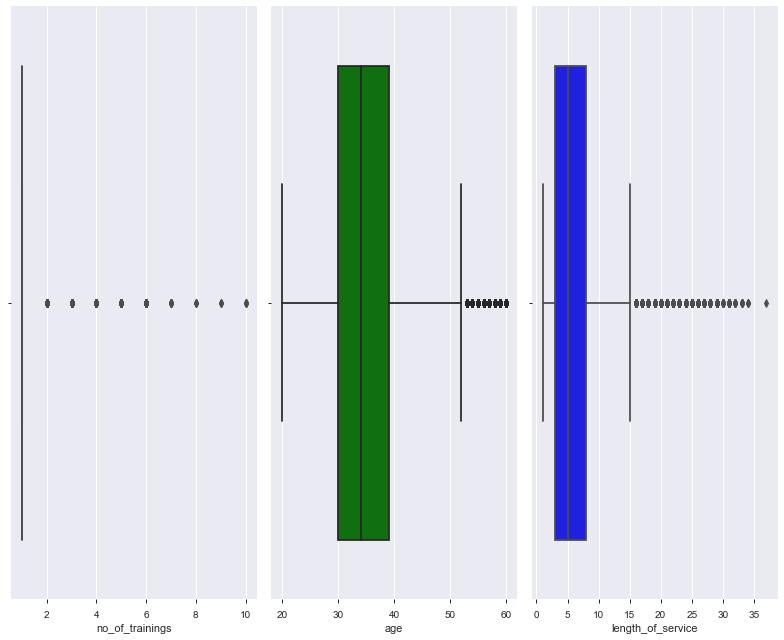

In [8]:
#Checking the box plot of the first 6 columns
plt.figure(figsize=[11,9])
plt.subplot(131)
sns.boxplot(pm_data.iloc[:,6],color='r')
plt.subplot(132)
sns.boxplot(pm_data.iloc[:,7],color='g')
plt.subplot(133)
sns.boxplot(pm_data.iloc[:,9],color='b')
plt.tight_layout()
plt.show()

`age` and `length_of_service` contain a lot of outliers. They have be scaled. 

<b>Scaling the input features</b>

Let us first analyze the distribution of data in these two columns

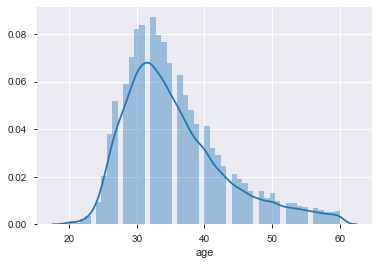

In [9]:
sns.distplot(pm_data['age'])

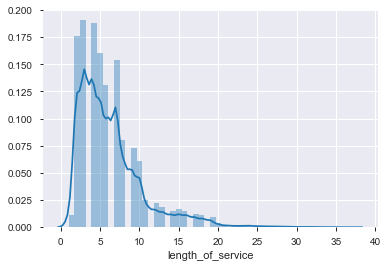

In [10]:
sns.distplot(pm_data['length_of_service'])

`age` seems to be following a perfect <b>normal distribution</b> whereas `length_of_service` seems to have a skewed distribution. Let us normalize both these columns by using <b>Z-scores.</b>

In [5]:
pm_data_norm = pm_data[['age','length_of_service']]

In [6]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(pm_data_norm)

In [13]:
X_std

array([[-0.07823179,  0.40155619],
       [-0.74184639, -0.54975648],
       [-0.21095471,  0.16372803],
       ...,
       [ 0.18721405, -0.07410014],
       [-1.14001516, -0.78758464],
       [-1.14001516, -0.31192831]])

In [7]:
fdf_normalized = pd.DataFrame(data=X_std, index=pm_data_norm.index, columns=pm_data_norm.columns)

Let us now analyze <b>Categorical</b> columns

Convert the `is_promoted` column to a <b>categorical</b> column

In [8]:
pm_data['is_promoted'] = pd.Categorical(pm_data['is_promoted']).codes

In [16]:
pm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             48660 non-null int64
department              48660 non-null object
region                  48660 non-null object
education               48660 non-null object
gender                  48660 non-null object
recruitment_channel     48660 non-null object
no_of_trainings         48660 non-null int64
age                     48660 non-null int64
previous_year_rating    48660 non-null float64
length_of_service       48660 non-null int64
KPIs_met >80%           48660 non-null int64
awards_won?             48660 non-null int64
avg_training_score      48660 non-null int64
is_promoted             48660 non-null int8
dtypes: float64(1), int64(7), int8(1), object(5)
memory usage: 5.2+ MB


<b>Data Visualizations</b>

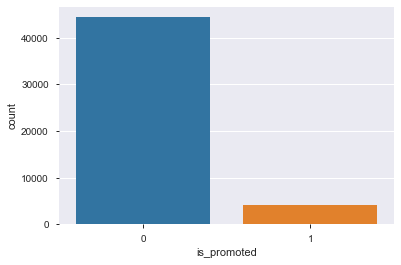

In [17]:
sns.countplot(x='is_promoted',data=pm_data)

We are dealing with an <b>imbalanced</b> dataset

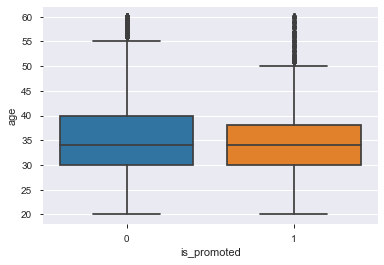

In [19]:
#Relation between Age and Promotion
sns.boxplot(x='is_promoted', y='age', data=pm_data)
plt.show()

Observation: `age` seems to have <b>minimal</b> impact on the promotion

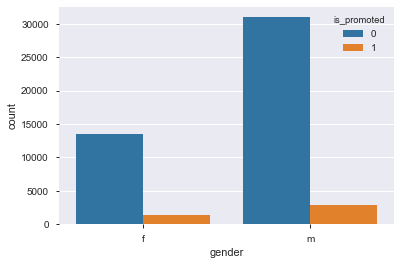

In [20]:
#Gender analysis
sns.countplot(x='gender', data=pm_data, hue='is_promoted')
plt.show()

Observation: You can see that there are more <b>male</b> employees than female employees in the dataset. Also the proportion of employees promoted seems to be more or less the <b>same</b> across both the genders.

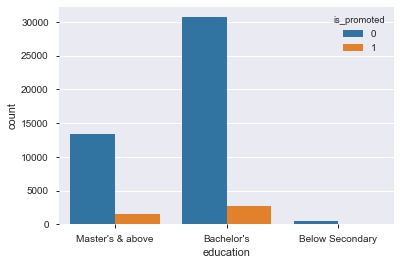

In [21]:
#Education analysis
sns.countplot(x='education',data=pm_data,hue='is_promoted')

<b>Observation:</b> People with <b>Below Secondary</b> education have not been promoted

## Feature Engineering

Convert <b>Categorical</b> columns to dummy variables.

In [9]:
cols=['department','education','gender','recruitment_channel']                                                      # These are the categorical columns
cat_cols=pm_data[cols]
cat_cols=cat_cols.astype(str)

In [23]:
cat_cols.head()

,department,education,gender,recruitment_channel
0,Sales & Marketing,Master's & above,f,sourcing
1,Operations,Bachelor's,m,other
2,Sales & Marketing,Bachelor's,m,sourcing
3,Sales & Marketing,Bachelor's,m,other
4,Technology,Bachelor's,m,other


In [10]:
dummies=pd.get_dummies(cat_cols,drop_first=True)

In [25]:
dummies.head()

,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,1,0,1
3,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0


Combine the dummy variables with original data

In [11]:
input_features=pd.concat([pm_data,dummies],axis=1)

In [27]:
input_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 27 columns):
employee_id                     48660 non-null int64
department                      48660 non-null object
region                          48660 non-null object
education                       48660 non-null object
gender                          48660 non-null object
recruitment_channel             48660 non-null object
no_of_trainings                 48660 non-null int64
age                             48660 non-null int64
previous_year_rating            48660 non-null float64
length_of_service               48660 non-null int64
KPIs_met >80%                   48660 non-null int64
awards_won?                     48660 non-null int64
avg_training_score              48660 non-null int64
is_promoted                     48660 non-null int8
department_Finance              48660 non-null uint8
department_HR                   48660 non-null uint8
department_Legal                48660

Drop the original <b>categorical</b> columns.

In [12]:
input_features.drop(cols, axis=1, inplace=True)

Combine the dataset with the normalized values of `age` and `length_of_service` columns.

In [32]:
input_features.drop(['age','length_of_service'], axis=1, inplace=True)

In [33]:
input_features = pd.concat([input_features, fdf_normalized],axis=1)

In [34]:
input_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 23 columns):
employee_id                     48660 non-null int64
region                          48660 non-null object
no_of_trainings                 48660 non-null int64
previous_year_rating            48660 non-null float64
KPIs_met >80%                   48660 non-null int64
awards_won?                     48660 non-null int64
avg_training_score              48660 non-null int64
is_promoted                     48660 non-null int8
department_Finance              48660 non-null uint8
department_HR                   48660 non-null uint8
department_Legal                48660 non-null uint8
department_Operations           48660 non-null uint8
department_Procurement          48660 non-null uint8
department_R&D                  48660 non-null uint8
department_Sales & Marketing    48660 non-null uint8
department_Technology           48660 non-null uint8
education_Below Secondary       48660 non

In [35]:
y=input_features.loc[:,'is_promoted']
input_features.drop(['is_promoted','region','employee_id'],axis=1,inplace=True)
X=input_features

In [36]:
X.head()

,no_of_trainings,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing,age,length_of_service
0,1,5.0,1,0,49,0,0,0,0,0,0,1,0,0,1,0,0,1,-0.078232,0.401556
1,1,5.0,0,0,60,0,0,0,1,0,0,0,0,0,0,1,0,0,-0.741846,-0.549756
2,1,3.0,0,0,50,0,0,0,0,0,0,1,0,0,0,1,0,1,-0.210955,0.163728
3,2,1.0,0,0,50,0,0,0,0,0,0,1,0,0,0,1,0,0,0.452660,0.877213
4,1,3.0,0,0,73,0,0,0,0,0,0,0,1,0,0,1,0,0,1.248997,-1.025413


**Train-Test split for training and validation**

Since we are dealing with an imbalanced dataset, we will use the <b>stratify</b> parameter to ensure equal distribution of classes in the training and test datasets

In [37]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1234,stratify=y)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(34062, 20)
(14598, 20)
(34062,)
(14598,)


## Logistic Regression

Since it is an imbalanced dataset, we will set the <b>class_weight</b> parameter to 'balanced'

In [38]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101,class_weight='balanced')

In [39]:
lr_model=lr.fit(x_train,y_train)

C:\Users\Prerna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
lr_pred=lr_model.predict(x_test)

0.7595561035758323
********************************************
Confusion matrix


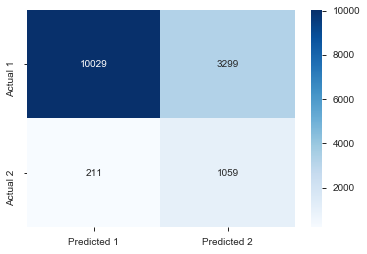

**********************************************
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     13328
           1       0.24      0.83      0.38      1270

    accuracy                           0.76     14598
   macro avg       0.61      0.79      0.61     14598
weighted avg       0.92      0.76      0.81     14598



In [41]:
print(metrics.accuracy_score(y_test,lr_pred))
print('********************************************')
print('Confusion matrix')
lr_cfm=metrics.confusion_matrix(y_test, lr_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(lr_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('**********************************************')
print(metrics.classification_report(y_test,lr_pred))

<b>Accuracy</b> is not so great here. Also, since this is an imbalanced dataset, we need to pay attention to the <b>f1-score</b> for class 1. It is also not so good.

This might be due to the fact that there are a lot of <b>categorical variables</b> in the dataset. As there is a lot of <b>non-linearity</b>, let us use <b>tree</b> algorithms.

## Random Forest

We will try the <b>Bagging</b> technique <b>Random Forest</b> on the dataset. Since we do not know the optimal hyperparameters for the forest, let us use GridSearch cross-validation to identify them.

#### GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_grid = {'n_estimators': range(5,20,3),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [5,10,20,30],
              'min_samples_split':[2,5,10],
              'criterion':['entropy'],
              'min_samples_leaf':[1,2,4]}

rf=RandomForestClassifier(oob_score=True,class_weight='balanced')
rf_gs = GridSearchCV(rf, random_grid, cv = 5, n_jobs=-1, verbose=2)

rf_gs.fit(x_train, y_train)
y_pred = rf_gs.predict(x_test)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.2min


In [ ]:
print(metrics.accuracy_score(y_test,y_pred))
print('*******************************************')
print('Confusion matrix')
rf_cfm=metrics.confusion_matrix(y_test, y_pred)

lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(rf_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('********************************************')
print(metrics.classification_report(y_test,y_pred))

That seems to be a great accuracy score! But hold on...we need to remember that it is an imbalanced dataset. Let us calculate the null accuracy.

In [ ]:
# Actual Values of y_test
print (y_test.value_counts())
print ("Null Accuracy:",y_test.value_counts().head(1) / len(y_test))

<b>Null accuracy</b> itself is close to 0.91. So our accuracy of 0.92 is not a big deal. Also, as discussed earlier, f1-score is more important in these scenarios. But even that is pretty low. By the way, is <b>f1-score</b> still the right metric in this scenario?

For imbalanced datasets, <b>ROC_AUC</b> is considered to be a more relevant metric than <b>f1-score and accuracy<b> as it is independent of threshold value. 

In [ ]:
predict_probabilities = rf_gs.predict_proba(x_test)
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print (final_metric)

Now, this is a metric that makes sense. We should get the <b>ROC_AUC</b> score as close to 1 as possible. Let us now see how <b>Boosting</b> algorithms fare.

**XGBoost**<br/>

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(num_class = 2,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42) 

In [ ]:
xgb_model.fit(x_train, y_train)

In [268]:
xgboost_pred=xgb_model.predict(x_test)

0.9391697492807234
************
Confusion matrix


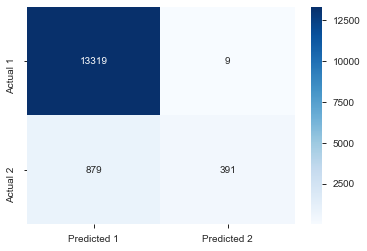

************
 Classification report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13328
           1       0.98      0.31      0.47      1270

    accuracy                           0.94     14598
   macro avg       0.96      0.65      0.72     14598
weighted avg       0.94      0.94      0.92     14598



In [269]:
print(metrics.accuracy_score(y_test,xgboost_pred))
print('************')
print('Confusion matrix')
xgboost_cm=metrics.confusion_matrix(y_test, xgboost_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgboost_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('************\n Classification report')
print(metrics.classification_report(y_test,xgboost_pred))

In [270]:
predict_probabilities = xgb_model.predict_proba(x_test)
from sklearn.metrics import roc_auc_score
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print (final_metric)

0.9059446810220151


Hurray! <b>Xgboost</b> gave us a higher ROC_AUC score compared to Random Forest. Let us see if we can make this better by tuning the real strengths of Xgboost - its <b>Hyperparameters.</b> 

**XgBoost with Grid Search**

In [181]:
xgb_gs_clf = XGBClassifier(num_class = 2,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20],
              "n_estimators": range(5,20,5) , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}
#              "min_child_weight": [5,10], 
#              "colsample_bytree": [0.4,0.8], 
#              "subsample": [0.50,0.85]} 

grid_search = GridSearchCV(xgb_gs_clf, 
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(x_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.3min finished


{'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 15}

In [182]:
xgboost_y_pred=grid_search.predict(x_test)                                      # Validating the model by predicting the test data

0.9366351555007535
*************************************************
Confusion matrix


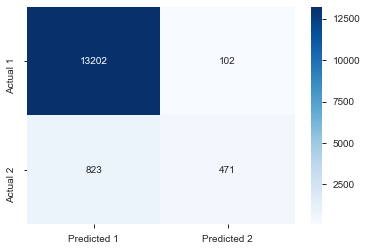

***************************************************
 Classification report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     13304
           1       0.82      0.36      0.50      1294

    accuracy                           0.94     14598
   macro avg       0.88      0.68      0.74     14598
weighted avg       0.93      0.94      0.93     14598



In [183]:
print(metrics.accuracy_score(y_test,xgboost_y_pred))
print('*************************************************')
print('Confusion matrix')
xgboost_cfm=metrics.confusion_matrix(y_test, xgboost_y_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgboost_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,xgboost_y_pred))

In [185]:
predict_probabilities = grid_search.predict_proba(x_test)
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print (final_metric)

0.8953667349467127


Not much of an improvement over the earlier Xgboost model. Try out with <b>more hyperparameter combinations</b> and you will surely see a jump in the roc_auc value.

Finally, let us see how <b>LightGBM</b> fares

**LightGBM**

In [186]:
import lightgbm as lgb

d_train= lgb.Dataset(x_train, label = y_train)                                        # LightGBM dataset format

In [187]:
params = {}
params['learning_rate'] = 0.001                                             # Learning rate
params['boosting_type'] = 'gbdt'                                           # gbdt = gradient boosted decision tree
params['objective'] = 'multiclass'                                         # Multi class classification
params['metric'] = 'multi_logloss'
params['num_classes'] = 5 
params['eval_metric']='auc', 'binary_logloss'
#params['sub_feature'] = 0.5
#params['min_data'] = 50
#params['max_depth'] = 10


clf = lgb.train(params, d_train)                                                      # Training the model for 10 iterations

In [188]:
#Prediction
y_pred=clf.predict(x_test)

In [189]:
clf.params

{'learning_rate': 0.001,
 'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_classes': 5,
 'eval_metric': ('auc', 'binary_logloss')}

In [198]:
predictions = []
predictions_proba = []
for x in y_pred:
    predictions.append(np.argmax(x))
    predictions_proba.append(max(x))

In [193]:
lgb_y_pred = np.array(predictions)

0.9113577202356488
*************************************************
Confusion matrix


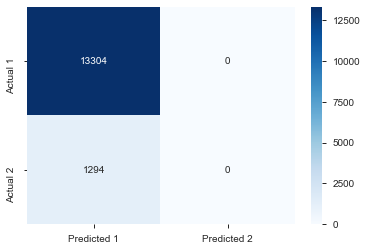

***************************************************
 Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13304
           1       0.00      0.00      0.00      1294

    accuracy                           0.91     14598
   macro avg       0.46      0.50      0.48     14598
weighted avg       0.83      0.91      0.87     14598



C:\Users\saicharantej\ML\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [194]:
print(metrics.accuracy_score(y_test,lgb_y_pred))
print('*************************************************')
print('Confusion matrix')
lgb_cfm=metrics.confusion_matrix(y_test, lgb_y_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(lgb_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,lgb_y_pred))

In [196]:
final_metric = roc_auc_score(y_test, predictions_proba)
print (final_metric)

0.11707243571095978


<b>LightGBM</b> performance is not upto the mark.It is unable to correctly classify even a single datapoint that belonged to class 1. We can conclude that <b>Palmer Tech</b> can use the <b>XGboost</b> model to identify the promotion candidates.